<a href="https://colab.research.google.com/github/taitip-supha/DeepLearn-Keras/blob/main/04_AutoEncoder/AutoEncoder_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Prepar the Enviroment

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-31710348-a917-cd23-5ac7-bbfbe47e8db3)


In [ ]:
#Import package
import sys,os,time,datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
NumPy 1.21.5
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
#Set fixed seeding values for reproducability during experiments
#to guarantee reproducability, make sure valuesfor any randomize poperation are all set
np.random.seed(1234)
tf.random.set_seed(5678)

# 1.MLP - Auto Encoder for Digit Reconstruction in MNIST Dataset

## 1.1 Prepare the MNIST dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [ ]:
# Inspect MNIST dataset
print( f"Training set: x_train = {x_train.shape}, y_train = {y_train.shape}")
print( f"Testing  set: x_test  = {x_test.shape},  y_test  = {y_test.shape}")

Training set: x_train = (60000, 28, 28), y_train = (60000,)
Testing  set: x_test  = (10000, 28, 28),  y_test  = (10000,)


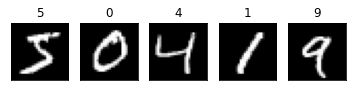

In [ ]:
#Plot the first five image in x_train
for i in range(5):
   plt.subplot(150+1+i).set_title(y_train[i])
   plt.imshow( x_train[i] ,cmap=plt.get_cmap('gray'))
   plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [ ]:
#Covert each pixel from unsigned int 8-bit (0-255) data type to 32-bit floating point data type
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [ ]:
# Input normalization from 0-255 to 0.0 - 1.0
x_train /= 255
x_test /= 255

In [ ]:
# For MLP-Based, convert each 2D image of 28*28 pixels into 1D vector of 28*28 = 784 
x_train = x_train.reshape( x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape( x_test.shape[0], x_test.shape[1]*x_test.shape[2])
print( f"New x_train shape = {x_train.shape}")
print( f"New x_test  shape = {x_test.shape} ")

New x_train shape = (60000, 784)
New x_test  shape = (10000, 784) 


## 1.2 Create the network architecture

In [ ]:
#Input Layers
mlp_ae_input = tf.keras.layers.Input( shape=(784,), name="input_image")
mlp_ae_noise = tf.keras.layers.Dropout(0.5, name='denoised_image')(mlp_ae_input)

# Encoder used MLP
mlp_ae_encoder = tf.keras.layers.Dense(512, activation='relu', name='encoder_layer')(mlp_ae_noise)

# latent variable
mlp_ae_latent = tf.keras.layers.Dense(32, activation='relu', name='Latent_variable')(mlp_ae_encoder)

#Decoder 
mlp_ae_decoder = tf.keras.layers.Dense(512, activation='relu', name='decoder_layer' )(mlp_ae_latent)

#output
mlp_ae_output = tf.keras.layers.Dense(784, activation='sigmoid', name='output_image')(mlp_ae_decoder) #set output same original image

mlp_ae_model = tf.keras.models.Model(mlp_ae_input, mlp_ae_output)

mlp_ae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 784)]             0         
                                                                 
 denoised_image (Dropout)    (None, 784)               0         
                                                                 
 encoder_layer (Dense)       (None, 512)               401920    
                                                                 
 Latent_variable (Dense)     (None, 32)                16416     
                                                                 
 decoder_layer (Dense)       (None, 512)               16896     
                                                                 
 output_image (Dense)        (None, 784)               402192    
                                                                 
Total params: 837,424
Trainable params: 837,424
Non-trainable

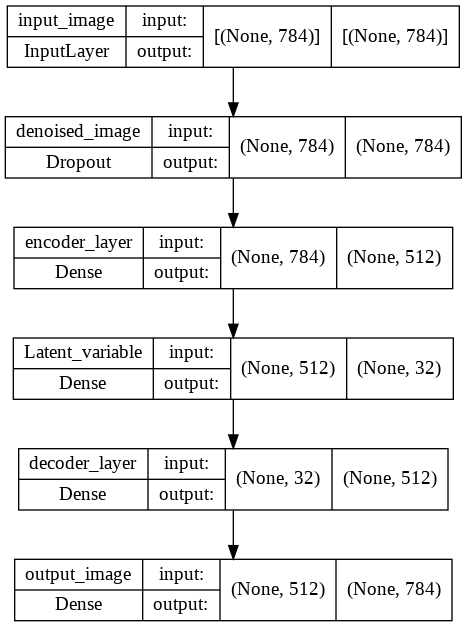

In [ ]:
tf.keras.utils.plot_model(mlp_ae_model, "mpl_ae_ex11-1.png", show_shapes=True, show_layer_names=True)

## 1.3 Compile and train the model

### Compile and train the model

In [ ]:
def root_mean_squared_error(y_true, y_pred):
  x = tf.keras.backend.square( y_pred-y_true ) #Shape (batch_size, w*h)
  y = tf.keras.backend.mean(x, axis=-1) #Shape (batch_size,)
  return tf.keras.backend.sqrt(y) #Shape (batch_size,)

In [ ]:
#Choose loss function (only one)
mlp_ae_model.compile( loss=root_mean_squared_error, optimizer='adam', metrics=['mae'] )
#mlp_ae_model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

### Create a custom callback

In [ ]:
my_history = dict()
class GenerativeModel_Eval( tf.keras.callbacks.Callback ):
  def __init__(self ,epochs, n=5) :
     """ 
     Arguments:
       epochs(int) : how many epochs to train the model
       n (int) : evaluate the model once for every 'n' epoch passed
     """
     super(GenerativeModel_Eval, self).__init__()
     self.__epochs = epochs
     self.__n = n if n>0 else 5

  def on_epoch_begin( self, epoch, logs=None):
     if epoch % self.__n == 0:
       self.__predict_with_current_model( epoch )

  def on_train_end( self, logs=None):
     for k,v in self.model.history.history.items():
       my_history[k] = v.copy()
     self.__predict_with_current_model( self.__epochs)
  
  def __predict_with_current_model(self, current_epoch, n_samples=6):
     """ 
     Argument:
       current_epoch (int) : the number of current epoch
       n_sample (int) : evaluate the first 'n_sample' samples in the test set """
    
     #Use the current model to predict x_test[0] - x_test[n-cols-1]
     n_cols = n_samples
     n_rows = 2

     #Prepare 2-row of image (each row contains n_cols images)
     fig_h =5
     fig, axes = plt.subplots( n_rows, n_cols, figsize=( (fig_h * n_cols) // n_rows, fig_h) )
     fig.suptitle( f"******** Model after being train for {current_epoch} epochs" )
     for i in range(n_cols):
        x_recon = self.model.predict( np.array( [x_test[i] ] ) )

        # First row is original x_test image
        axes[0, i].set_title( f" x_test[{i}] = {y_test[i] }" )
        axes[0, i].imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )

        # Second row is the reconstructed image by auto encoder
        axes[1, i].imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )

     plt.show()


### Train the model

For Auto Encoder use only x for training the model. No need for the lable y

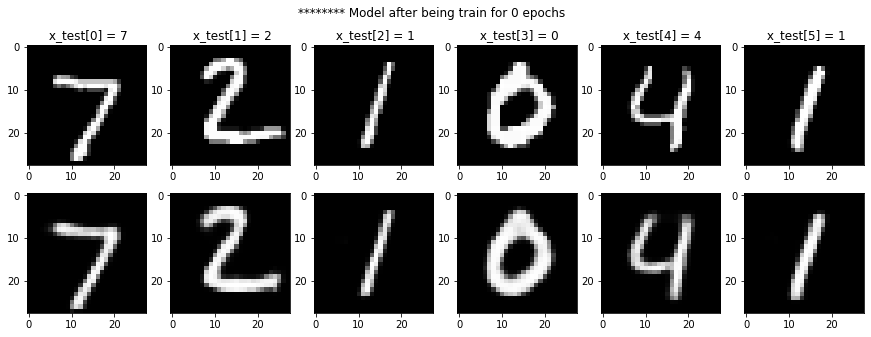

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1007 - mae: 0.0353 - val_loss: 0.0861 - val_mae: 0.0308
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1004 - mae: 0.0351 - val_loss: 0.0860 - val_mae: 0.0308


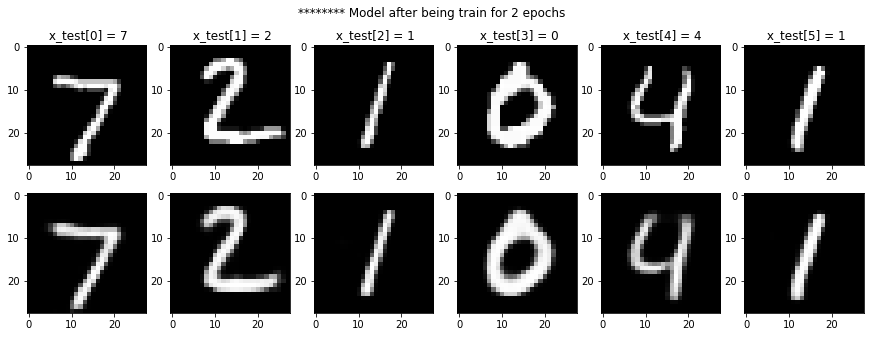

Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1003 - mae: 0.0350 - val_loss: 0.0860 - val_mae: 0.0306
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1000 - mae: 0.0349 - val_loss: 0.0855 - val_mae: 0.0306


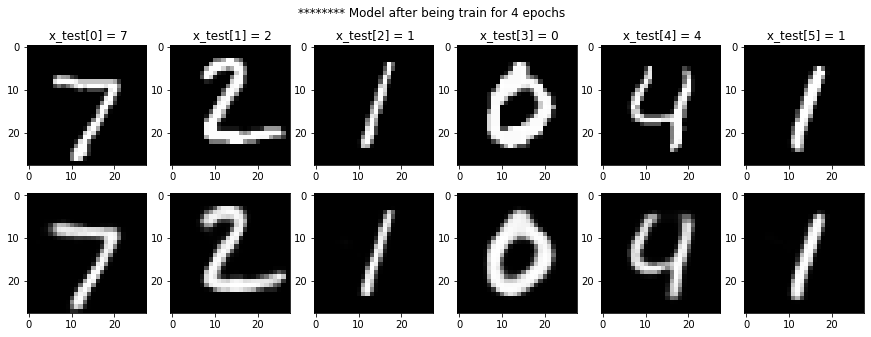

Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0998 - mae: 0.0348 - val_loss: 0.0845 - val_mae: 0.0302
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0997 - mae: 0.0347 - val_loss: 0.0850 - val_mae: 0.0303


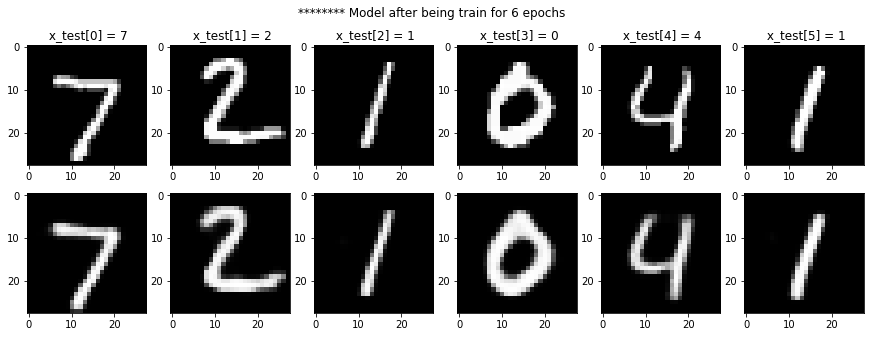

Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0995 - mae: 0.0346 - val_loss: 0.0857 - val_mae: 0.0306
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0992 - mae: 0.0345 - val_loss: 0.0858 - val_mae: 0.0306


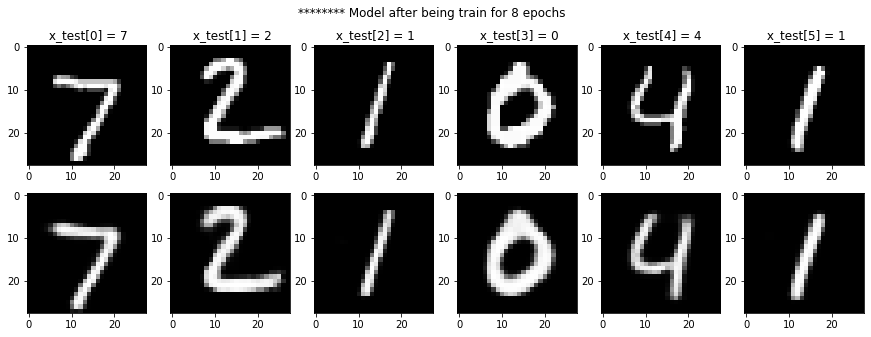

Epoch 9/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0990 - mae: 0.0344 - val_loss: 0.0851 - val_mae: 0.0303
Epoch 10/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0990 - mae: 0.0344 - val_loss: 0.0841 - val_mae: 0.0301


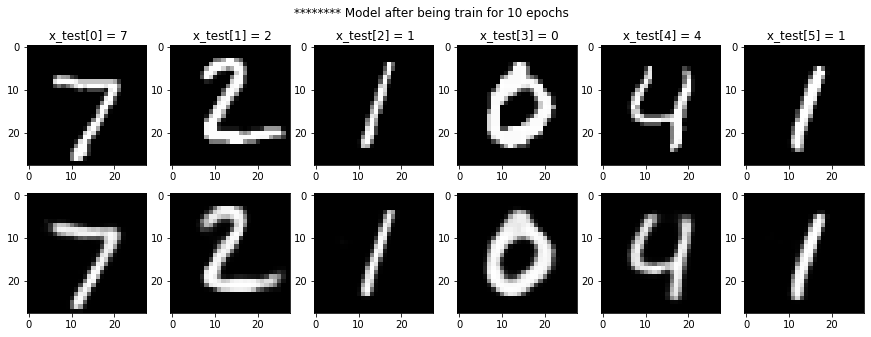

Epoch 11/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0987 - mae: 0.0343 - val_loss: 0.0844 - val_mae: 0.0299
Epoch 12/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0986 - mae: 0.0342 - val_loss: 0.0851 - val_mae: 0.0300


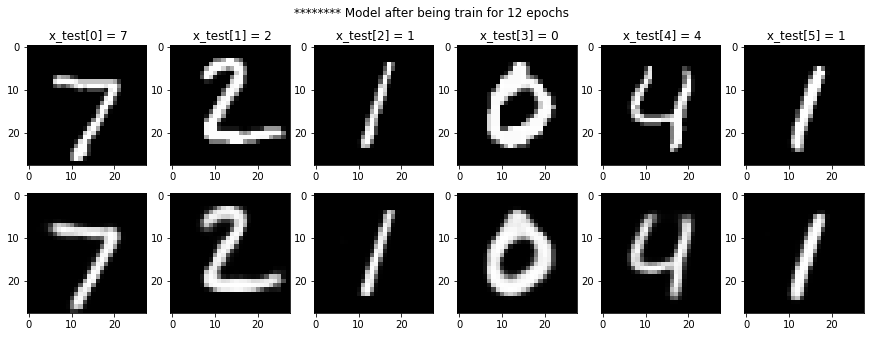

Epoch 13/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0985 - mae: 0.0341 - val_loss: 0.0838 - val_mae: 0.0298
Epoch 14/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0983 - mae: 0.0341 - val_loss: 0.0840 - val_mae: 0.0297


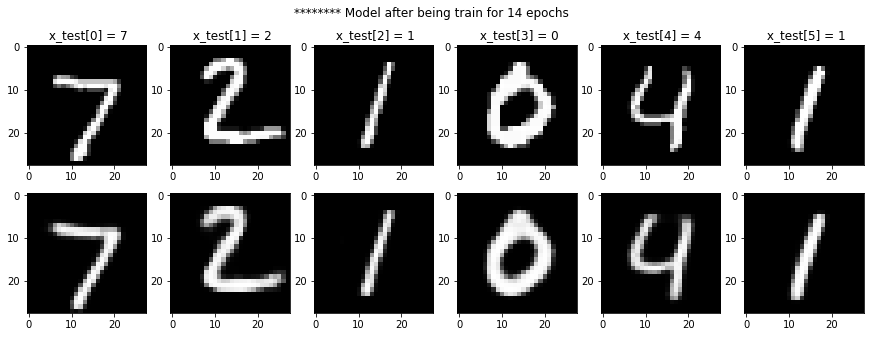

Epoch 15/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0982 - mae: 0.0340 - val_loss: 0.0837 - val_mae: 0.0296
Epoch 16/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0980 - mae: 0.0339 - val_loss: 0.0838 - val_mae: 0.0295


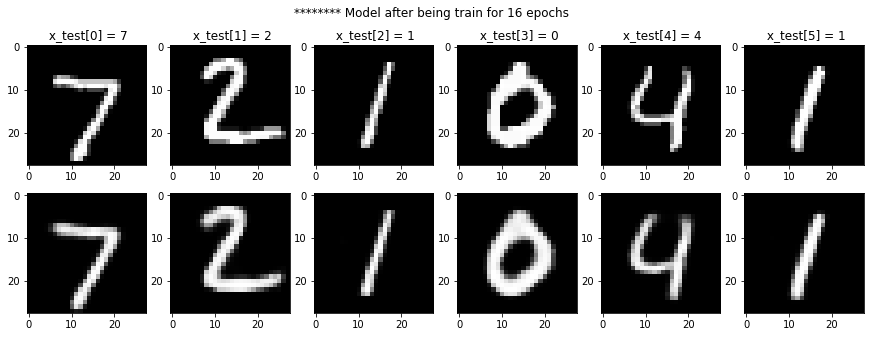

Epoch 17/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0980 - mae: 0.0339 - val_loss: 0.0842 - val_mae: 0.0297
Epoch 18/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0980 - mae: 0.0339 - val_loss: 0.0846 - val_mae: 0.0297


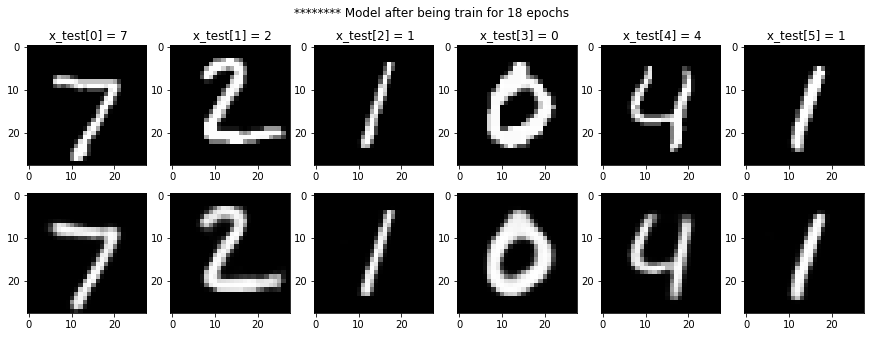

Epoch 19/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0979 - mae: 0.0339 - val_loss: 0.0836 - val_mae: 0.0294
Epoch 20/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0977 - mae: 0.0338 - val_loss: 0.0828 - val_mae: 0.0292


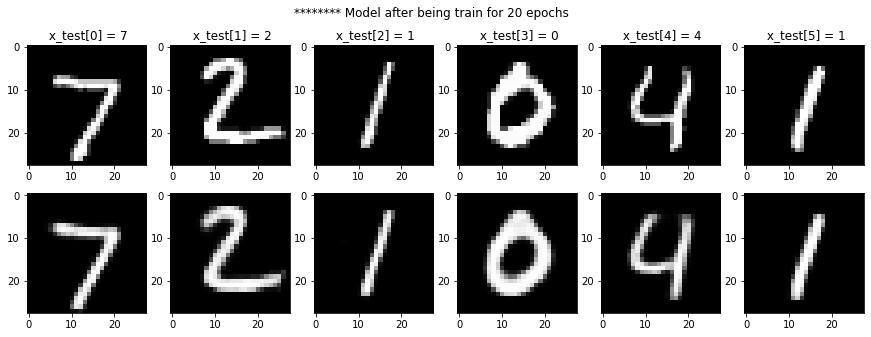

In [ ]:
n_epochs = 20
ex1_hist = mlp_ae_model.fit( x_train, x_train, validation_data=( x_test, x_test ),
                            batch_size=128, epochs=n_epochs, verbose=1, callbacks=[ GenerativeModel_Eval(n_epochs,2)] ) 

In [ ]:
#Check the key in history
print( f"ex1_hist.history.keys() : {ex1_hist.history.keys()}" )
print( f"my_history.keys() : {my_history.keys()}" )

ex1_hist.history.keys() : dict_keys([])
my_history.keys() : dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


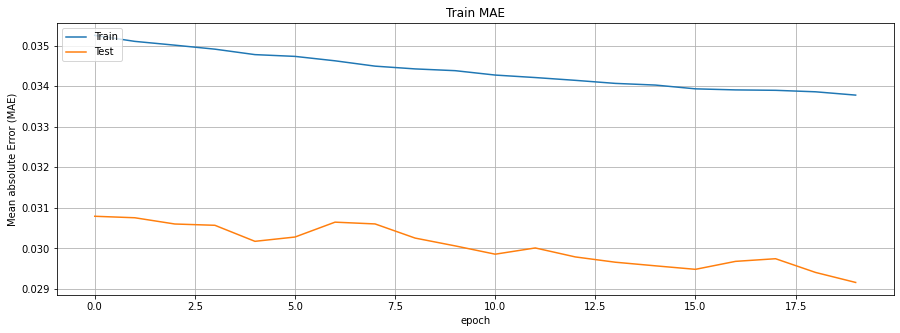

In [ ]:
# Summarize history for mean absolute error(mae)/Accuracy
if 'mae' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['mae'] )
  plt.plot( my_history['val_mae'] )
  plt.title( 'Train MAE')
  plt.ylabel( 'Mean absolute Error (MAE)')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()
if 'acc' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['acc'] )
  plt.plot( my_history['val_acc'] )
  plt.title( 'Train Accuracy')
  plt.ylabel( 'Accuracy')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()

## 1.4 Evaluate the model on test set

In [ ]:
ex1_result = mlp_ae_model.evaluate( x_test, x_test, batch_size=128)
print(f"{mlp_ae_model.metrics_names} = {ex1_result}")

79/79 [==============================] - 0s 2ms/step - loss: 0.0828 - mae: 0.0292
['loss', 'mae'] = [0.08284226059913635, 0.029160698875784874]


## 1.5 Inference

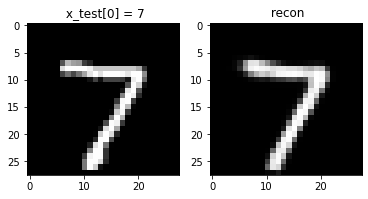

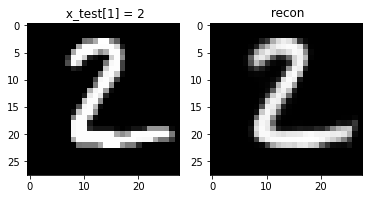

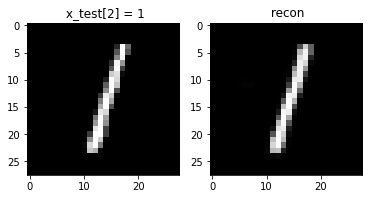

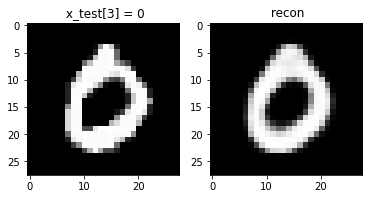

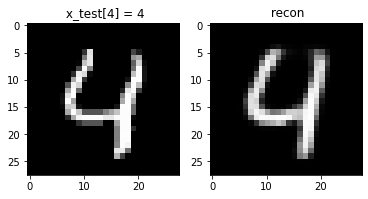

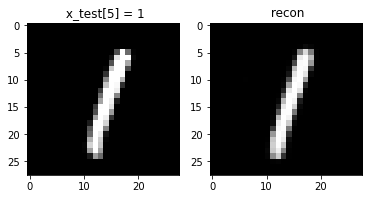

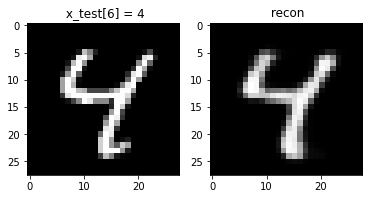

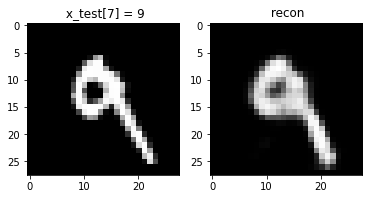

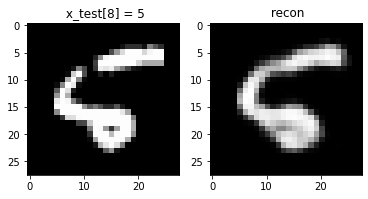

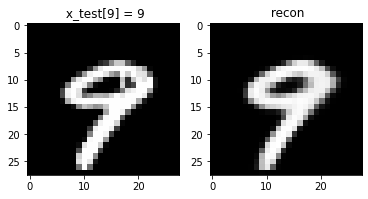

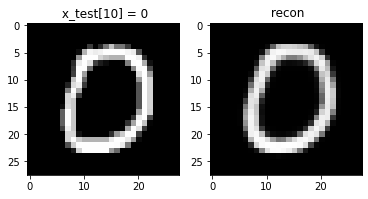

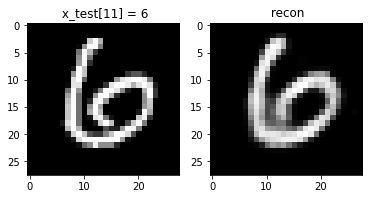

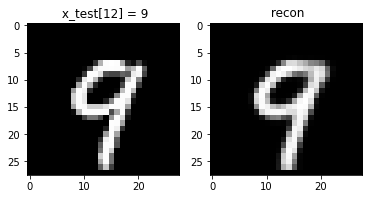

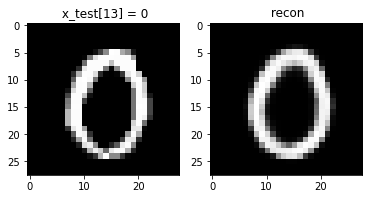

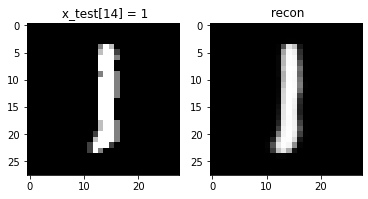

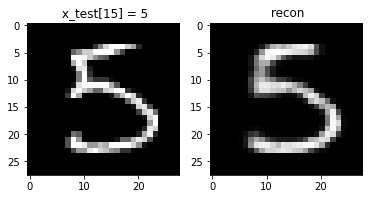

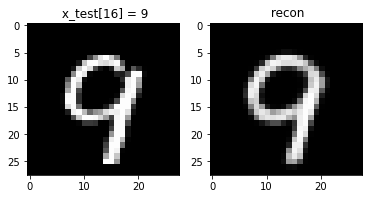

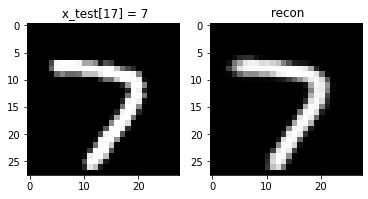

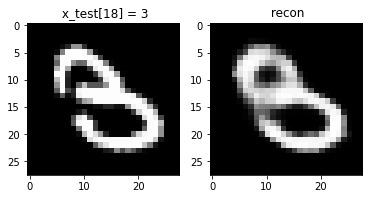

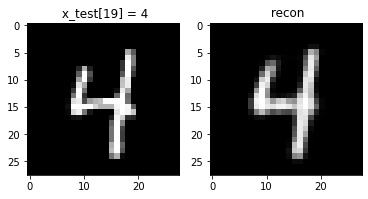

In [ ]:
n = 20
for i in range(n):
   x_recon = mlp_ae_model.predict( np.array( [x_test[i] ] ) )
   # First row is original x_test image
   plt.subplot(1,2,1).set_title( f" x_test[{i}] = {y_test[i] }" )
   plt.imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )
   # Second row is the reconstructed image by auto encoder
   plt.subplot(1,2,2).set_title( f" recon" )
   plt.imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )
   plt.show()

# 2.CNN-Auto Encoder for Digit Reconstruction in MNIST Dataset

## 2.1 Prepare the MNIST dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
# Inspect MNIST dataset
print( f"Training set: x_train = {x_train.shape}, y_train = {y_train.shape}")
print( f"Testing  set: x_test  = {x_test.shape},  y_test  = {y_test.shape}")

Training set: x_train = (60000, 28, 28), y_train = (60000,)
Testing  set: x_test  = (10000, 28, 28),  y_test  = (10000,)


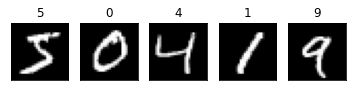

In [ ]:
#Plot the first five image in x_train
for i in range(5):
   plt.subplot(150+1+i).set_title(y_train[i])
   plt.imshow( x_train[i] ,cmap=plt.get_cmap('gray'))
   plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [ ]:
#Covert each pixel from unsigned int 8-bit (0-255) data type to 32-bit floating point data type
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [ ]:
# Input normalization from 0-255 to 0.0 - 1.0
x_train /= 255
x_test /= 255

In [ ]:
# For CNN-Based, input remains a batch of 2D images
x_train = x_train.reshape( x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape( x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print( f"New x_train shape = {x_train.shape}")
print( f"New x_test  shape = {x_test.shape} ")

New x_train shape = (60000, 28, 28, 1)
New x_test  shape = (10000, 28, 28, 1) 


## 2.2 Create the network architecture

In [ ]:
#Input Layers
cnn_ae_input = tf.keras.layers.Input( shape=(28, 28, 1), name="input_image")
cnn_ae_noise = tf.keras.layers.Dropout(0.5, name='denoised_image')(cnn_ae_input)

# Encoder used MLP
cnn_ae_encoder = tf.keras.layers.Conv2D( 64,   (3,3), activation='relu', padding='same', strides=2, name='encoder01')(cnn_ae_noise)
cnn_ae_encoder = tf.keras.layers.Conv2D( 128, (3,3), activation='relu', padding='same', strides=2, name='encoder02')(cnn_ae_encoder)

# latent variable
cnn_ae_latent = tf.keras.layers.Flatten()(cnn_ae_encoder)
cnn_ae_latent = tf.keras.layers.Dense(49, activation='softmax', name='Latent')(cnn_ae_latent)  #Output shape 1*49
cnn_ae_latent = tf.keras.layers.Reshape( (7,7,1) )(cnn_ae_latent) #Output shape 7*7

#Decoder 
cnn_ae_decoder = tf.keras.layers.Conv2DTranspose(128, (3,3), activation='relu',  padding='same', strides=2, name='decoder01' )(cnn_ae_latent) #Output shape 14*14 : 7 * (3-1)
cnn_ae_decoder = tf.keras.layers.Conv2DTranspose(64  , (3,3), activation='relu',  padding='same', strides=2, name='decoder02' )(cnn_ae_decoder) #Output shape 28*28 : 14 * (3-1)

#output
cnn_ae_output = tf.keras.layers.Conv2DTranspose(1  , (3,3), activation='sigmoid',  padding='same', name='output_img' )(cnn_ae_decoder) #Output shape 28*28

cnn_ae_model = tf.keras.models.Model(cnn_ae_input, cnn_ae_output)

cnn_ae_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 denoised_image (Dropout)    (None, 28, 28, 1)         0         
                                                                 
 encoder01 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 encoder02 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 Latent (Dense)              (None, 49)                307377    
                                                                 
 reshape (Reshape)           (None, 7, 7, 1)           0   

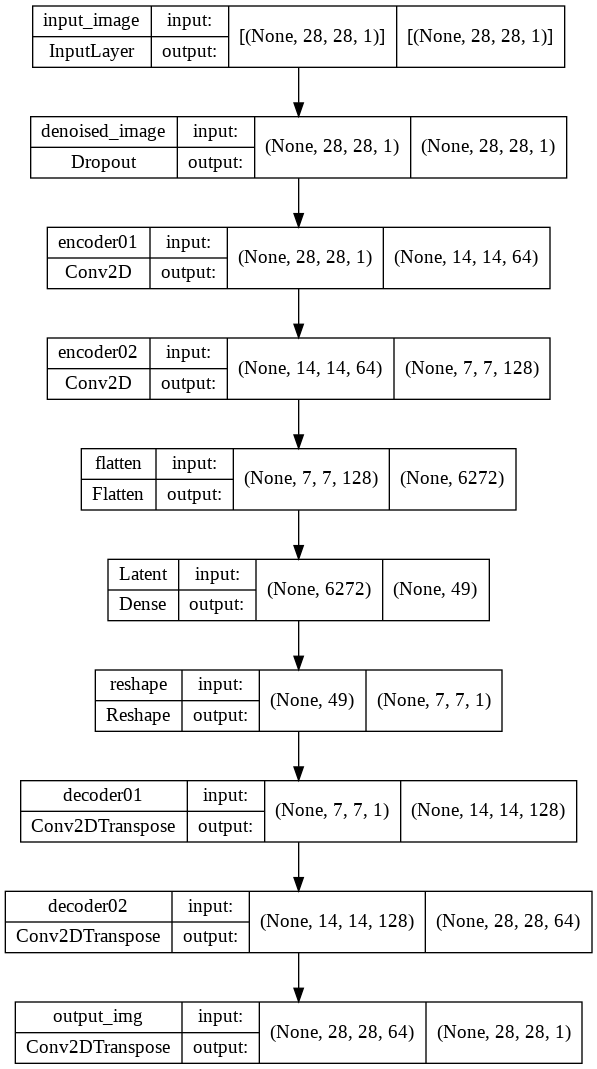

In [ ]:
tf.keras.utils.plot_model(cnn_ae_model, "CNN_ae_ex11-2.png", show_shapes=True, show_layer_names=True)

## 2.3 Compile and train the model

### >> Compile and train the model

In [ ]:
def root_mean_squared_error(y_true, y_pred):
  x = tf.keras.backend.square( y_pred-y_true ) #Shape (batch_size, w*h)
  y = tf.keras.backend.mean(x, axis=(1,2,3)) #Shape (batch_size,)
  return tf.keras.backend.sqrt(y) #Shape (batch_size,)

In [ ]:
#Choose loss function (only one)
cnn_ae_model.compile( loss=root_mean_squared_error, optimizer='adam', metrics=['mae'] )
#mlp_ae_model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['acc'] )

### >> Create a custom callback

In [ ]:
my_history = dict()
class GenerativeModel_Eval( tf.keras.callbacks.Callback ):
  def __init__(self ,epochs, n=5) :
     """ 
     Arguments:
       epochs(int) : how many epochs to train the model
       n (int) : evaluate the model once for every 'n' epoch passed
     """
     super(GenerativeModel_Eval, self).__init__()
     self.__epochs = epochs
     self.__n = n if n>0 else 5

  def on_epoch_begin( self, epoch, logs=None):
     if epoch % self.__n == 0:
       self.__predict_with_current_model( epoch )

  def on_train_end( self, logs=None):
     for k,v in self.model.history.history.items():
       my_history[k] = v.copy()
     self.__predict_with_current_model( self.__epochs)
  
  def __predict_with_current_model(self, current_epoch, n_samples=6):
     """ 
     Argument:
       current_epoch (int) : the number of current epoch
       n_sample (int) : evaluate the first 'n_sample' samples in the test set """
    
     #Use the current model to predict x_test[0] - x_test[n-cols-1]
     n_cols = n_samples
     n_rows = 2

     #Prepare 2-row of image (each row contains n_cols images)
     fig_h =5
     fig, axes = plt.subplots( n_rows, n_cols, figsize=( (fig_h * n_cols) // n_rows, fig_h) )
     fig.suptitle( f"******** Model after being train for {current_epoch} epochs" )
     for i in range(n_cols):
        x_recon = self.model.predict( np.array( [x_test[i] ] ) )

        # First row is original x_test image
        axes[0, i].set_title( f" x_test[{i}] = {y_test[i] }" )
        axes[0, i].imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )

        # Second row is the reconstructed image by auto encoder
        axes[1, i].imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )

     plt.show()


### >> Train the model

For Auto Encoder use only x for training the model. No need for the lable y

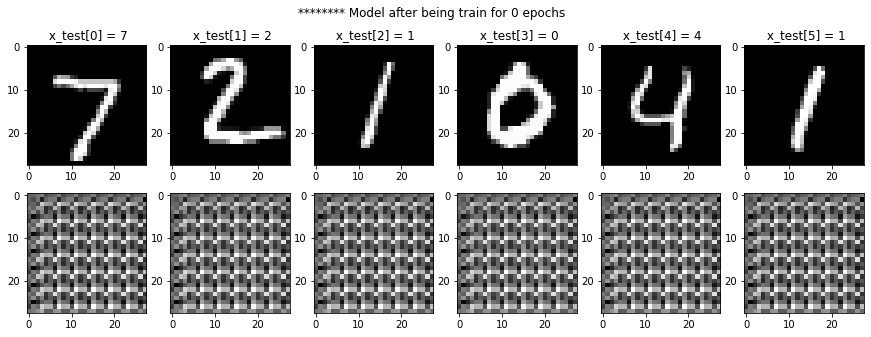

Epoch 1/20
469/469 [==============================] - 5s 9ms/step - loss: 0.2083 - mae: 0.1262 - val_loss: 0.2897 - val_mae: 0.1168
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1303 - mae: 0.0508 - val_loss: 0.2963 - val_mae: 0.1186


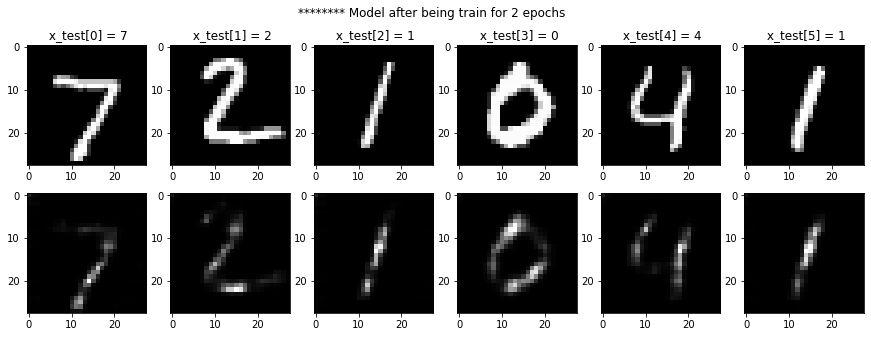

Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1254 - mae: 0.0475 - val_loss: 0.2696 - val_mae: 0.1072
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1230 - mae: 0.0460 - val_loss: 0.2637 - val_mae: 0.1048


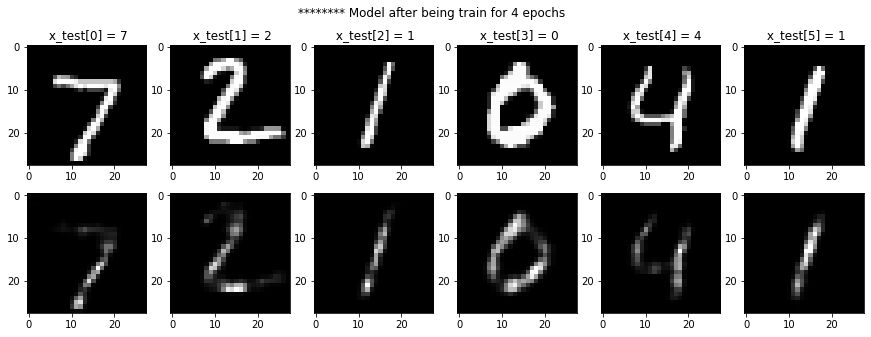

Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1213 - mae: 0.0451 - val_loss: 0.2438 - val_mae: 0.0965
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1203 - mae: 0.0444 - val_loss: 0.2331 - val_mae: 0.0922


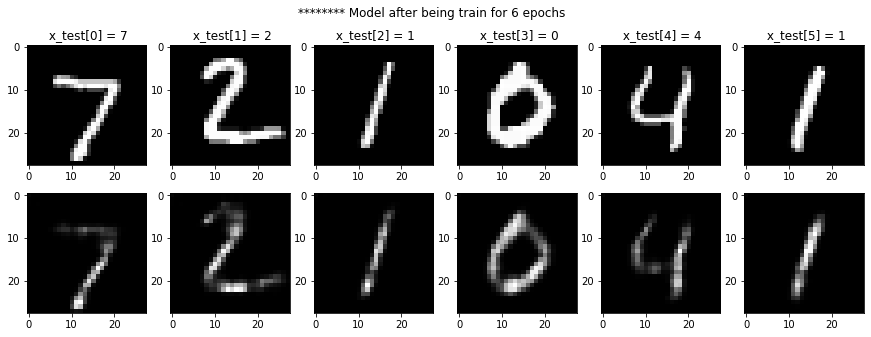

Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1192 - mae: 0.0439 - val_loss: 0.2196 - val_mae: 0.0866
Epoch 8/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1183 - mae: 0.0435 - val_loss: 0.2120 - val_mae: 0.0835


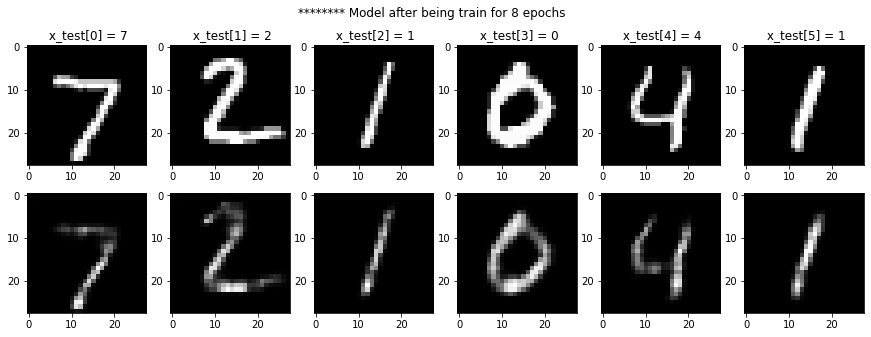

Epoch 9/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1179 - mae: 0.0432 - val_loss: 0.2165 - val_mae: 0.0854
Epoch 10/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1171 - mae: 0.0429 - val_loss: 0.2362 - val_mae: 0.0936


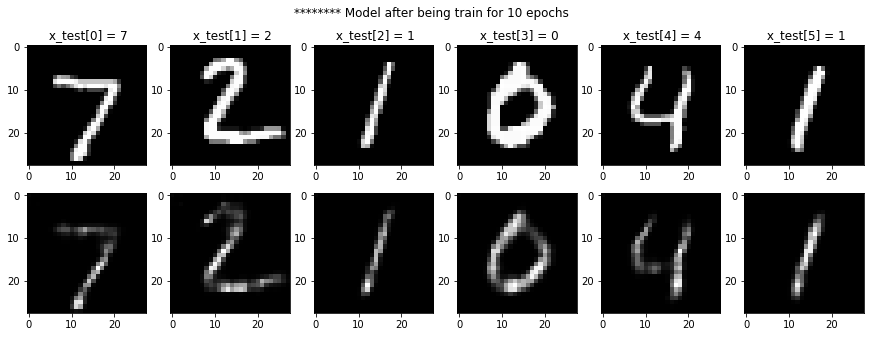

Epoch 11/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1164 - mae: 0.0426 - val_loss: 0.2060 - val_mae: 0.0813
Epoch 12/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1157 - mae: 0.0422 - val_loss: 0.1982 - val_mae: 0.0781


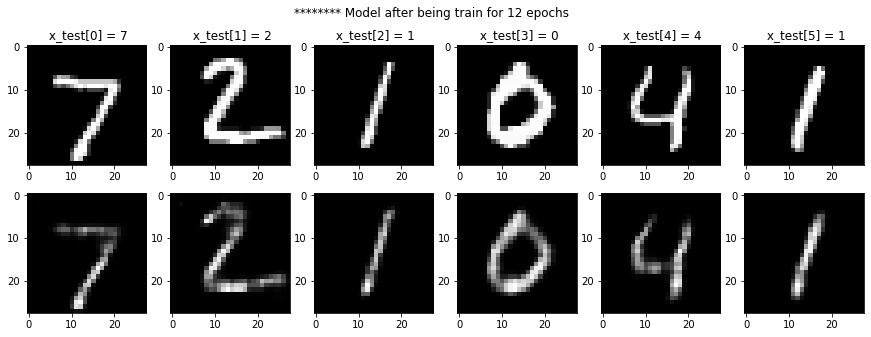

Epoch 13/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1152 - mae: 0.0420 - val_loss: 0.2101 - val_mae: 0.0829
Epoch 14/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1147 - mae: 0.0418 - val_loss: 0.1974 - val_mae: 0.0777


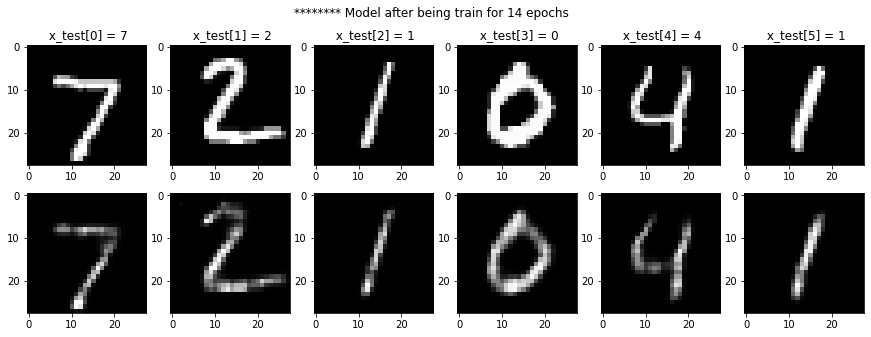

Epoch 15/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1140 - mae: 0.0415 - val_loss: 0.1876 - val_mae: 0.0738
Epoch 16/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1137 - mae: 0.0413 - val_loss: 0.1903 - val_mae: 0.0748


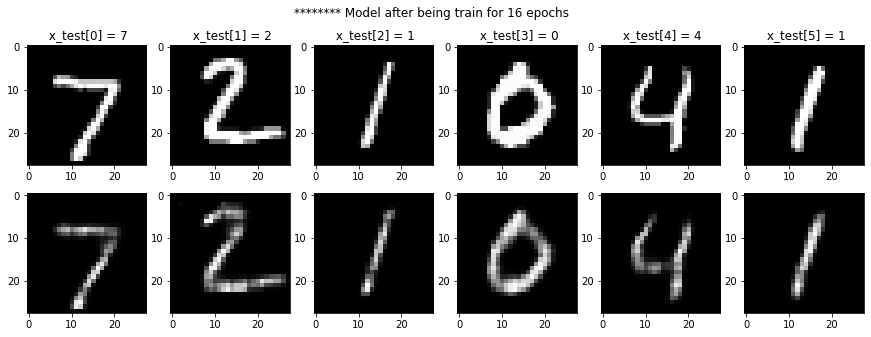

Epoch 17/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1132 - mae: 0.0411 - val_loss: 0.1957 - val_mae: 0.0771
Epoch 18/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1123 - mae: 0.0407 - val_loss: 0.1766 - val_mae: 0.0691


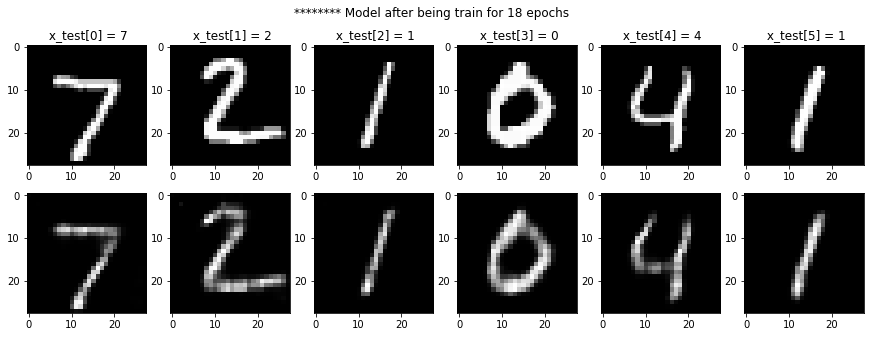

Epoch 19/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1119 - mae: 0.0404 - val_loss: 0.1739 - val_mae: 0.0681
Epoch 20/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1115 - mae: 0.0402 - val_loss: 0.1907 - val_mae: 0.0749


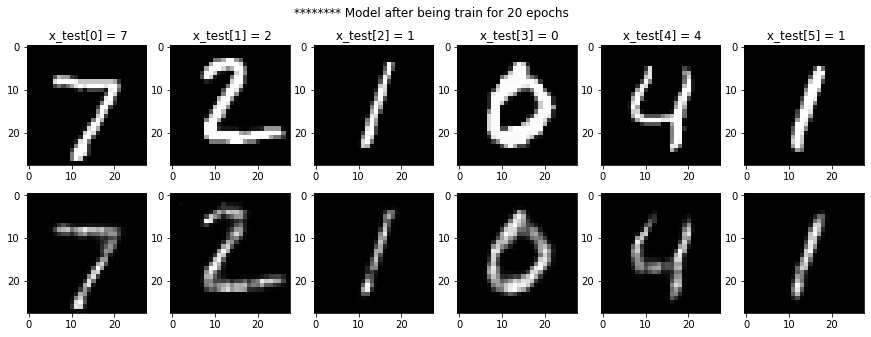

In [ ]:
n_epochs = 20
ex2_hist = cnn_ae_model.fit( x_train, x_train, validation_data=( x_test, x_test ),
                            batch_size=128, epochs=n_epochs, verbose=1, callbacks=[ GenerativeModel_Eval(n_epochs,2)] ) 

In [ ]:
#Check the key in history
print( f"ex2_hist.history.keys() : {ex2_hist.history.keys()}" )
print( f"my_history.keys() : {my_history.keys()}" )

ex2_hist.history.keys() : dict_keys([])
my_history.keys() : dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


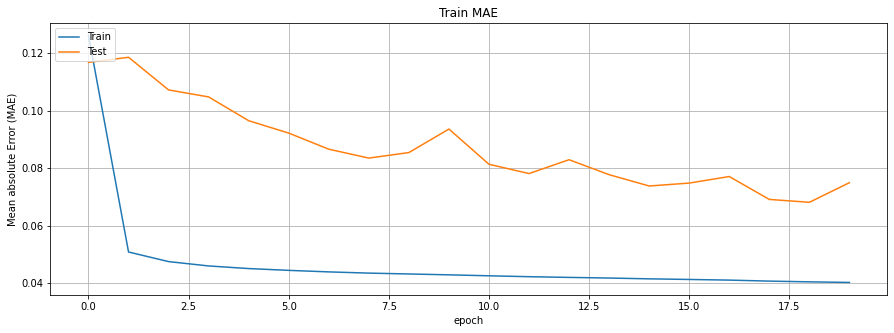

In [ ]:
# Summarize history for mean absolute error(mae)/Accuracy
if 'mae' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['mae'] )
  plt.plot( my_history['val_mae'] )
  plt.title( 'Train MAE')
  plt.ylabel( 'Mean absolute Error (MAE)')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()
if 'acc' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['acc'] )
  plt.plot( my_history['val_acc'] )
  plt.title( 'Train Accuracy')
  plt.ylabel( 'Accuracy')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()

## 2.4 Evaluate the model on test set

In [ ]:
ex2_result = cnn_ae_model.evaluate( x_test, x_test, batch_size=128)
print(f"{cnn_ae_model.metrics_names} = {ex2_result}")

79/79 [==============================] - 0s 4ms/step - loss: 0.1907 - mae: 0.0749
['loss', 'mae'] = [0.1907251477241516, 0.07494406402111053]


## 2.5 Inference

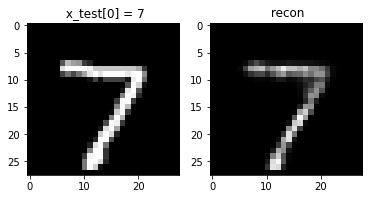

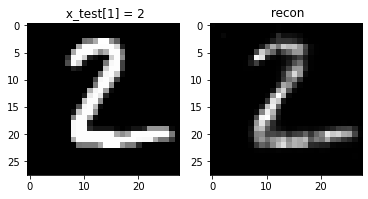

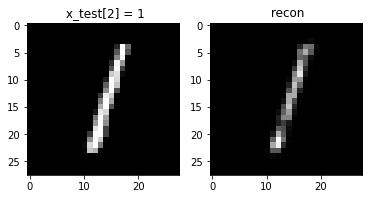

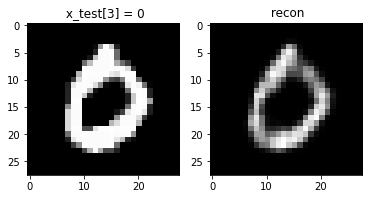

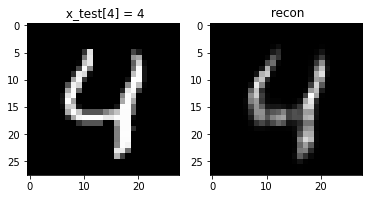

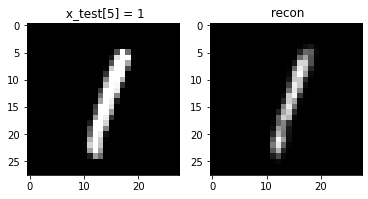

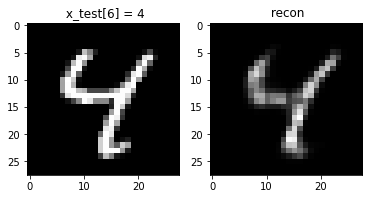

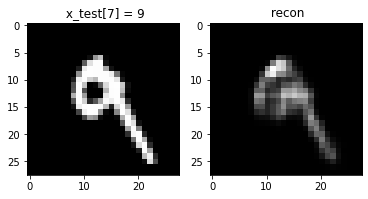

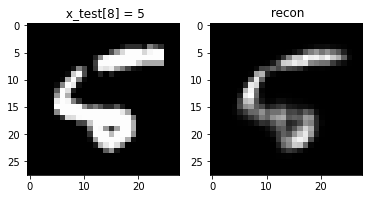

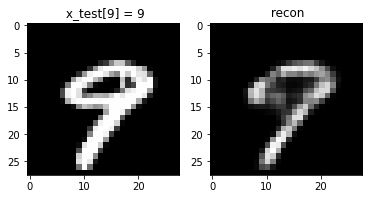

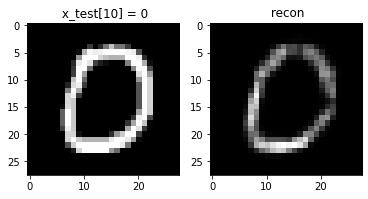

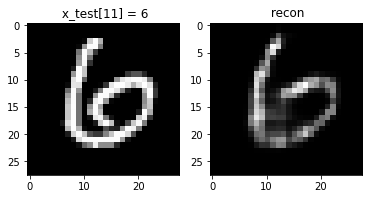

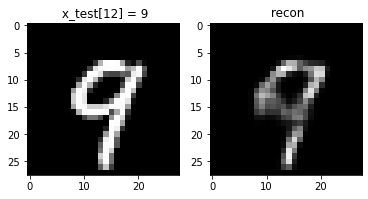

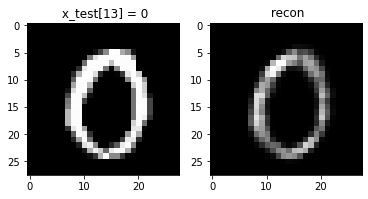

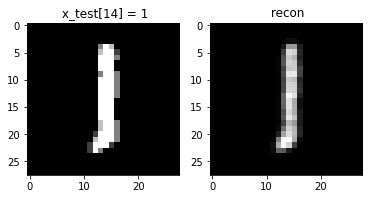

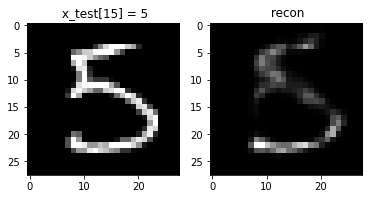

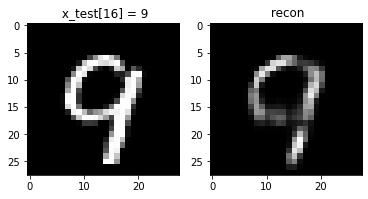

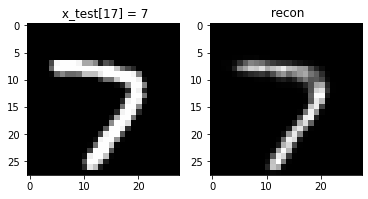

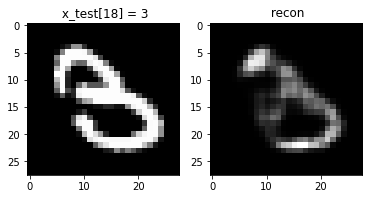

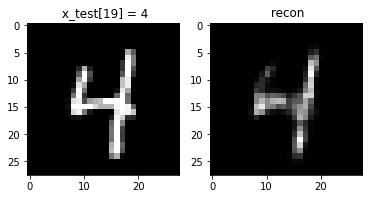

In [ ]:
n = 20
for i in range(n):
   x_recon = cnn_ae_model.predict( np.array( [x_test[i] ] ) )
   # First row is original x_test image
   plt.subplot(1,2,1).set_title( f" x_test[{i}] = {y_test[i] }" )
   plt.imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )
   # Second row is the reconstructed image by auto encoder
   plt.subplot(1,2,2).set_title( f" recon" )
   plt.imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )
   plt.show()

#  3.Variational AutoEncoder for Handwritten Digi Generation

The below cell is for disabling eager execution which is the default mode in tensorFlow 2.x. This is in order to use this example code that mix Keras and Tensorflow without getting an error at the fit function.
Other alternative is to use the whole low-level Tensorflow codes and a custom train loop as in https://keras.io/examples/generative/vae/

## 3.0 Set Disable eager execution

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
# Since TF 2.x, eager mode is enabled by default
print( f"Before : TF executing eagerly : {tf.executing_eagerly()}")

Before : TF executing eagerly : True


In [ ]:
if tf.executing_eagerly():
   disable_eager_execution()

print( f"After : TF executing eagerly : {tf.executing_eagerly()}")

After : TF executing eagerly : False


## 3.1 Prepare the MNIST dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Inspect MNIST dataset
print( f"Training set: x_train = {x_train.shape}, y_train = {y_train.shape}")
print( f"Testing  set: x_test  = {x_test.shape},  y_test  = {y_test.shape}")

Training set: x_train = (60000, 28, 28), y_train = (60000,)
Testing  set: x_test  = (10000, 28, 28),  y_test  = (10000,)


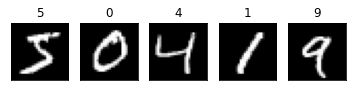

In [ ]:
#Plot the first five image in x_train
for i in range(5):
   plt.subplot(150+1+i).set_title(y_train[i])
   plt.imshow( x_train[i] ,cmap=plt.get_cmap('gray'))
   plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [ ]:
#Covert each pixel from unsigned int 8-bit (0-255) data type to 32-bit floating point data type
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [ ]:
# Input normalization from 0-255 to 0.0 - 1.0
x_train /= 255
x_test /= 255

In [ ]:
# Reshape to (batch_size, H, W, Channel)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print( f"New x_train shape = {x_train.shape}")
print( f"New x_test  shape = {x_test.shape} ")

New x_train shape = (60000, 28, 28, 1)
New x_test  shape = (10000, 28, 28, 1) 


## 3.2 Create the network architecture

### >> Create Sampling Layer

In [ ]:
class Sampling( tf.keras.layers.Layer ):
  """
  code from https://keras.io/examples/generative/vae/
  Reparameterization trick by sampling from an isotropic unit Gaussian.
  Instead of sampling from Q(z|X), we sample from epsilon = N(0,I).
  z = z_mean + sqrt(var) * epsilon, when z is an encoded latent vector
  """
  def call(self, inputs ):
    z_mean, z_logvar = inputs
    batch_size = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal( shape=(batch_size,dim) )
    return z_mean+tf.exp(0.5 * z_logvar)*epsilon

### >> Encoder

In [ ]:
latent_dim=2

in_img = tf.keras.layers.Input( shape=(28,28,1), name='input_img')
x = tf.keras.layers.Dropout(0.2)(in_img)

#Encoder
x = tf.keras.layers.Conv2D( 32, (3,3), activation='relu', padding='same', strides=2 ,name='encoder01')(x)
x = tf.keras.layers.Conv2D( 64, (3,3), activation='relu', padding='same', strides=2 ,name='encoder02')(x)

x = tf.keras.layers.Flatten()(x)

#### Bottlenneck ####
z_mean = tf.keras.layers.Dense( latent_dim, name='z_mean')(x)
z_logvar = tf.keras.layers.Dense( latent_dim, name='z_logvar')(x)

# Use reparameterization trick to push the simpling 
z = Sampling()([z_mean,z_logvar])

#Instantiate the encoder model
encoder = tf.keras.models.Model( in_img, [z_mean, z_logvar, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 dropout_2 (Dropout)            (None, 28, 28, 1)    0           ['input_img[0][0]']              
                                                                                                  
 encoder01 (Conv2D)             (None, 14, 14, 32)   320         ['dropout_2[0][0]']              
                                                                                                  
 encoder02 (Conv2D)             (None, 7, 7, 64)     18496       ['encoder01[0][0]']              
                                                                                            

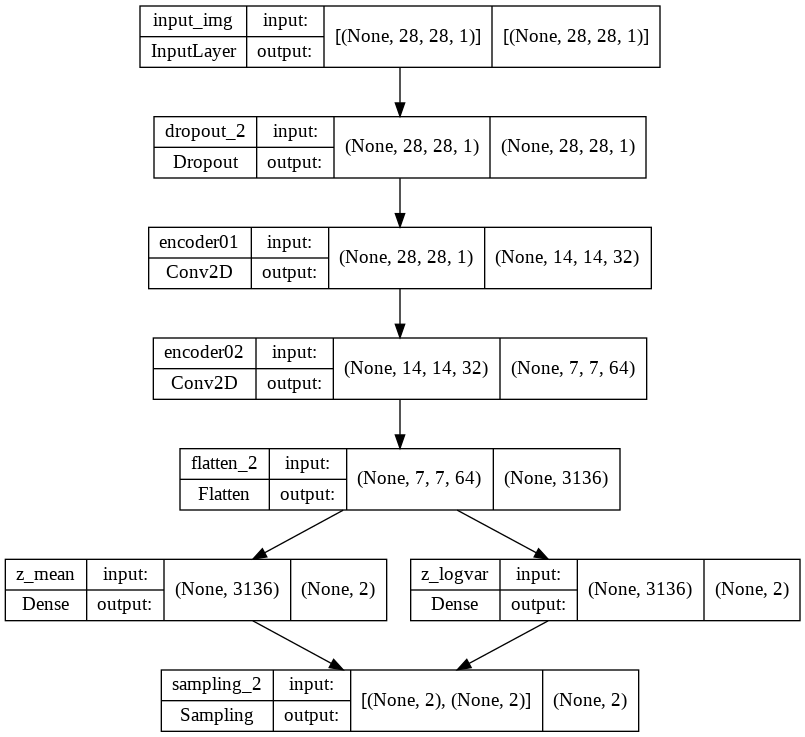

In [ ]:
tf.keras.utils.plot_model(encoder, "VAE_Encoder.png", show_shapes=True, show_layer_names=True)

###>> Decoder

In [ ]:
#### Decoder ####
latent_inputs = tf.keras.layers.Input( shape=(latent_dim,), name='z_sampling')

x = tf.keras.layers.Dense( 7*7*32 ,activation='relu')(latent_inputs)
x = tf.keras.layers.Reshape( (7,7,32) )(x)

x = tf.keras.layers.Conv2DTranspose( 64, (3,3), activation='relu', padding='same', strides=2, name='Decoder01')(x)
x = tf.keras.layers.Conv2DTranspose( 32, (3,3), activation='relu', padding='same', strides=2, name='Decoder02')(x)

#output
out_img = tf.keras.layers.Conv2DTranspose( 1, (3,3), activation='sigmoid', padding='same', name='output_img')(x)

# Instantiate the decoder model
decoder = tf.keras.models.Model( latent_inputs, out_img, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 1568)              4704      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 32)          0         
                                                                 
 Decoder01 (Conv2DTranspose)  (None, 14, 14, 64)       18496     
                                                                 
 Decoder02 (Conv2DTranspose)  (None, 28, 28, 32)       18464     
                                                                 
 output_img (Conv2DTranspose  (None, 28, 28, 1)        289       
 )                                                               
                                                           

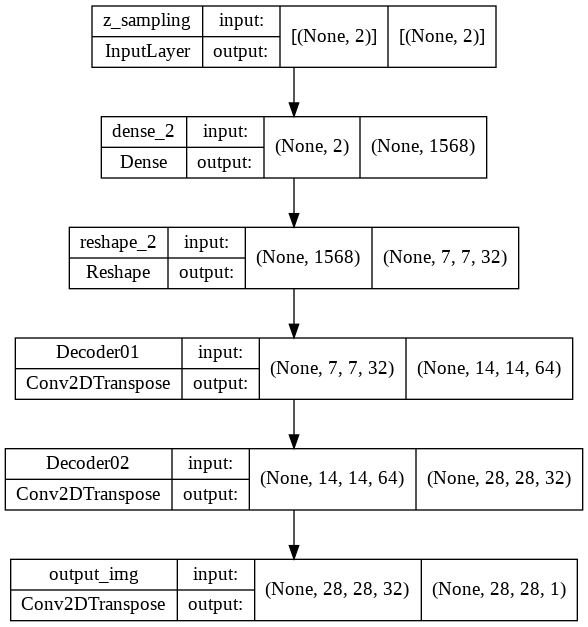

In [ ]:
tf.keras.utils.plot_model(decoder, "VAE_Decoder.png", show_shapes=True, show_layer_names=True)

###>> Construct VAE Model

In [ ]:
# Amoung the thee output of encoder, send only the last one (=z) to decoder
vae_out = decoder( encoder(in_img)[2] )

#Instantiate AVE model
vae = tf.keras.models.Model( in_img, vae_out, name='vae_cnn_model' )
vae.summary()

Model: "vae_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               31364     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         41953     
                                                                 
Total params: 73,317
Trainable params: 73,317
Non-trainable params: 0
_________________________________________________________________


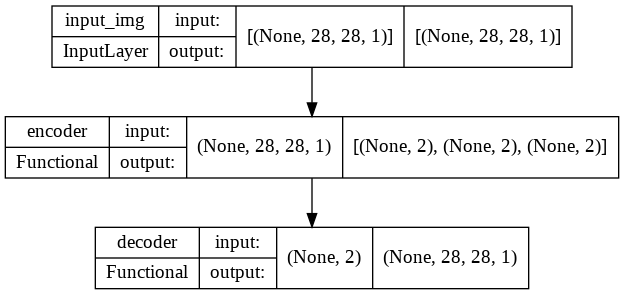

In [ ]:
tf.keras.utils.plot_model(vae, "VAE_CNN_model.png", show_shapes=True, show_layer_names=True)

## 3.3 Compile and Train the model

### >> Compile the model

In [ ]:
def vae_loss( y_true, y_pred ):
   #Original reconstruction loss choose one from two lines below
   recon_loss = tf.keras.backend.square( y_pred-y_true )
   recon_loss =  tf.keras.backend.mean(recon_loss, axis=None)
   recon_loss = tf.keras.backend.sqrt(recon_loss)
   #recon_loss = tf.keras.losses.binary_crossentropy( y_true, y_pred)
   # Extract two output vectors from the 'encoder'
   z_mean = vae.get_layer('encoder').get_layer('z_mean').output
   z_logvar = vae.get_layer('encoder').get_layer('z_logvar').output

   # latent loss
   latent_loss = 1 + z_logvar - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_logvar)
   latent_loss = tf.keras.backend.sum( latent_loss, axis=None ) 
   latent_loss *= -0.5

   return tf.keras.backend.mean( (recon_loss * 784 *100) + latent_loss )

In [ ]:
vae.compile( optimizer='rmsprop', loss=vae_loss, metrics=["acc"] )

### >> Create a custom callback

In [ ]:
my_history = dict()
class GenerativeModel_Eval( tf.keras.callbacks.Callback ):
  def __init__(self ,epochs, n=5) :
     """ 
     Arguments:
       epochs(int) : how many epochs to train the model
       n (int) : evaluate the model once for every 'n' epoch passed
     """
     super(GenerativeModel_Eval, self).__init__()
     self.__epochs = epochs
     self.__n = n if n>0 else 5

  def on_epoch_begin( self, epoch, logs=None):
     if epoch % self.__n == 0:
       self.__predict_with_current_model( epoch )

  def on_train_end( self, logs=None):
     for k,v in self.model.history.history.items():
       my_history[k] = v.copy()
     self.__predict_with_current_model( self.__epochs)
  
  def __predict_with_current_model(self, current_epoch, n_samples=6):
     """ 
     Argument:
       current_epoch (int) : the number of current epoch
       n_sample (int) : evaluate the first 'n_sample' samples in the test set """
    
     #Use the current model to predict x_test[0] - x_test[n-cols-1]
     n_cols = n_samples
     n_rows = 2

     #Prepare 2-row of image (each row contains n_cols images)
     fig_h =5
     fig, axes = plt.subplots( n_rows, n_cols, figsize=( (fig_h * n_cols) // n_rows, fig_h) )
     fig.suptitle( f"******** Model after being train for {current_epoch} epochs" )
     for i in range(n_cols):
        x_recon = self.model.predict( np.array( [x_test[i] ] ) )

        # First row is original x_test image
        axes[0, i].set_title( f" x_test[{i}] = {y_test[i] }" )
        axes[0, i].imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )

        # Second row is the reconstructed image by auto encoder
        axes[1, i].imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )

     plt.show()


###>> Train the model

Train on 60000 samples, validate on 10000 samples


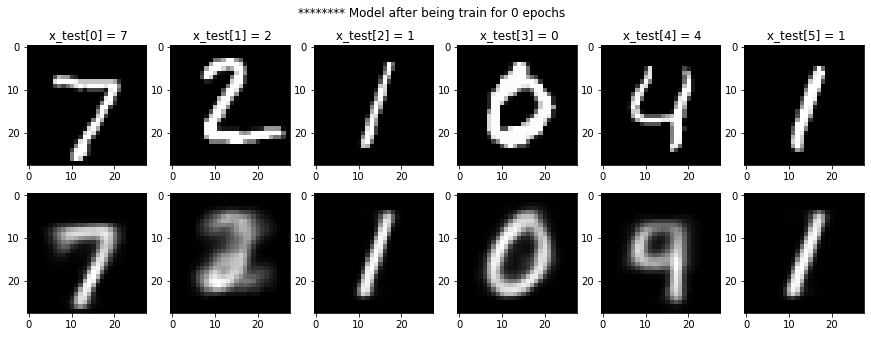

Epoch 1/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16974.4017 - acc: 0.7977 - val_loss: 17253.0115 - val_acc: 0.7999
Epoch 2/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16961.3556 - acc: 0.7977 - val_loss: 17057.2064 - val_acc: 0.7945
Epoch 3/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16952.4301 - acc: 0.7978 - val_loss: 16933.9135 - val_acc: 0.7976
Epoch 4/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16943.0705 - acc: 0.7978 - val_loss: 17160.4545 - val_acc: 0.7993
Epoch 5/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16940.9771 - acc: 0.7978 - val_loss: 17200.2985 - val_acc: 0.7984


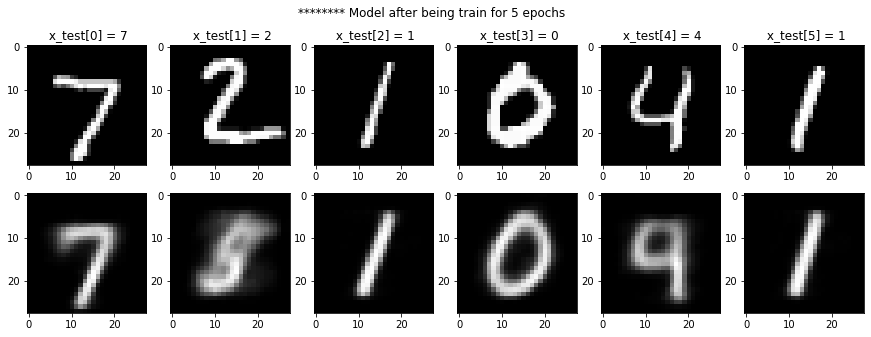

Epoch 6/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16923.8269 - acc: 0.7979 - val_loss: 16986.1005 - val_acc: 0.7972
Epoch 7/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16913.8133 - acc: 0.7979 - val_loss: 17310.3229 - val_acc: 0.7910
Epoch 8/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16908.1013 - acc: 0.7980 - val_loss: 17167.2068 - val_acc: 0.7940
Epoch 9/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16901.3265 - acc: 0.7980 - val_loss: 16984.3534 - val_acc: 0.7966
Epoch 10/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16893.8963 - acc: 0.7981 - val_loss: 17305.9010 - val_acc: 0.7959


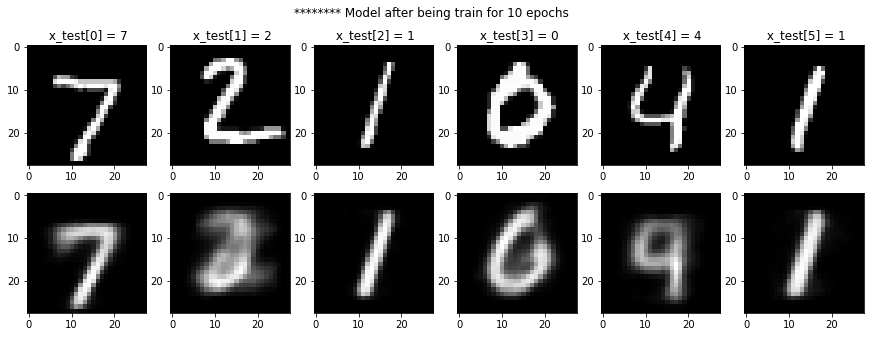

Epoch 11/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16886.4066 - acc: 0.7981 - val_loss: 17203.4942 - val_acc: 0.7957
Epoch 12/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16879.2533 - acc: 0.7982 - val_loss: 17231.3019 - val_acc: 0.7997
Epoch 13/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16874.5910 - acc: 0.7982 - val_loss: 17056.8214 - val_acc: 0.7978
Epoch 14/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16871.3005 - acc: 0.7982 - val_loss: 17109.6369 - val_acc: 0.7958
Epoch 15/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16863.8235 - acc: 0.7982 - val_loss: 17185.3832 - val_acc: 0.7984


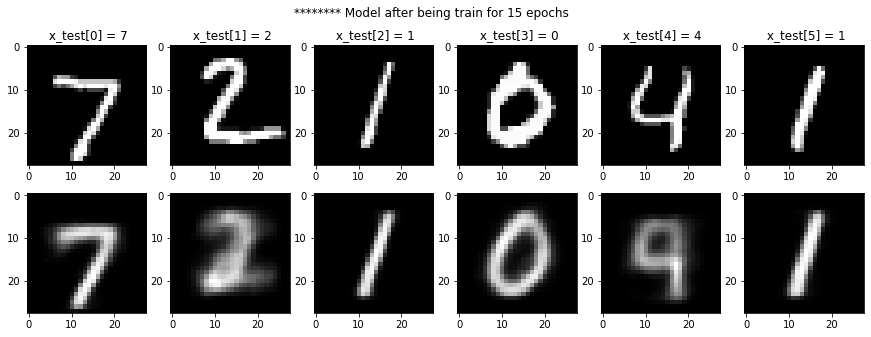

Epoch 16/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16854.7226 - acc: 0.7982 - val_loss: 17140.7940 - val_acc: 0.7961
Epoch 17/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16850.5903 - acc: 0.7982 - val_loss: 17016.4700 - val_acc: 0.7969
Epoch 18/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16847.9500 - acc: 0.7982 - val_loss: 16995.8032 - val_acc: 0.7977
Epoch 19/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16841.3272 - acc: 0.7982 - val_loss: 17291.4547 - val_acc: 0.7963
Epoch 20/20
60000/60000 [==============================] - 3s 50us/sample - loss: 16837.4283 - acc: 0.7983 - val_loss: 17086.4322 - val_acc: 0.7976


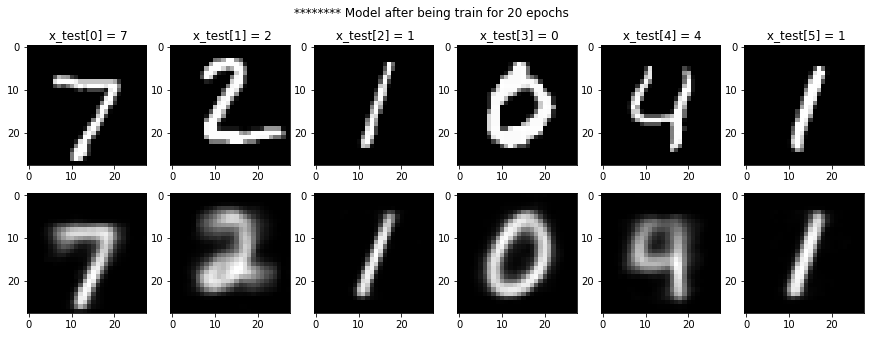

In [ ]:
n_epochs = 20
ex3_hist = vae.fit( x_train, x_train, validation_data=(x_test, x_test), 
                   batch_size=128, epochs=n_epochs, verbose=1, callbacks=[GenerativeModel_Eval(n_epochs,5) ])

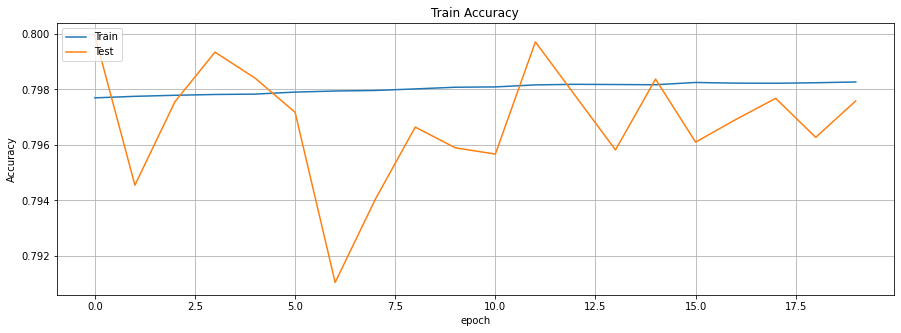

In [ ]:
# Summarize history for mean absolute error(mae)/Accuracy
if 'mae' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['mae'] )
  plt.plot( my_history['val_mae'] )
  plt.title( 'Train MAE')
  plt.ylabel( 'Mean absolute Error (MAE)')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()
if 'acc' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['acc'] )
  plt.plot( my_history['val_acc'] )
  plt.title( 'Train Accuracy')
  plt.ylabel( 'Accuracy')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()

## 3.4 Evaluate the model on test set

In [ ]:
ex3_result = vae.evaluate( x_test, x_test, batch_size=128)
print(f"{vae.metrics_names} = {ex3_result}")

['loss', 'acc'] = [17086.8954875, 0.797513]


## 3.5 Inference

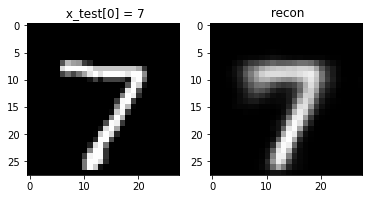

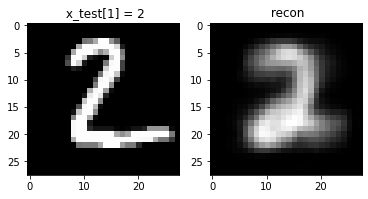

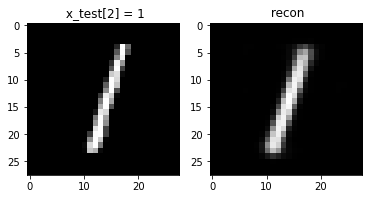

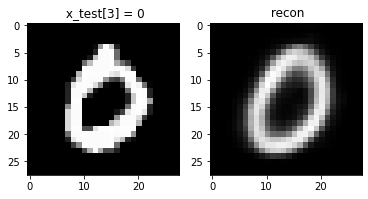

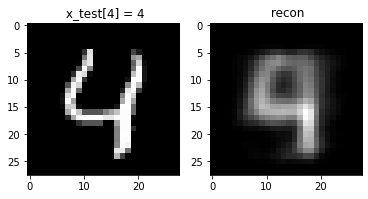

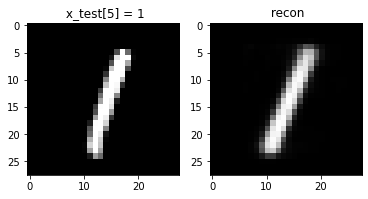

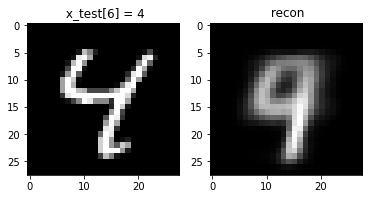

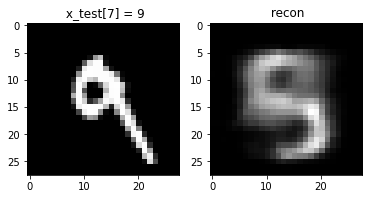

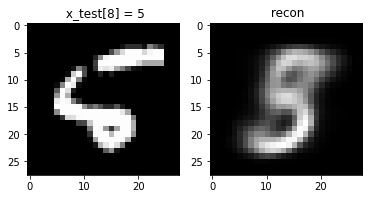

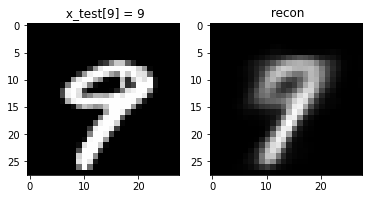

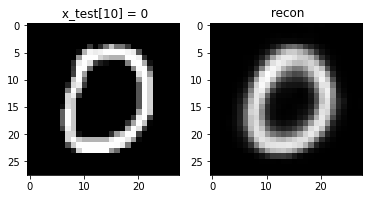

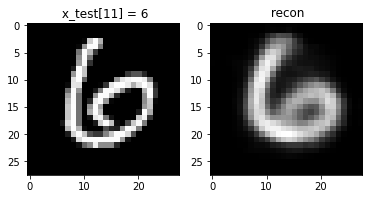

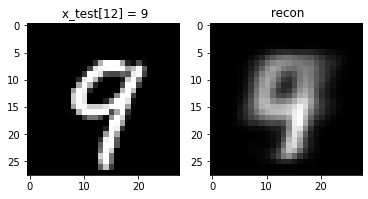

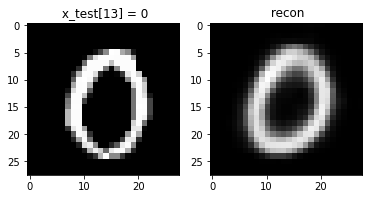

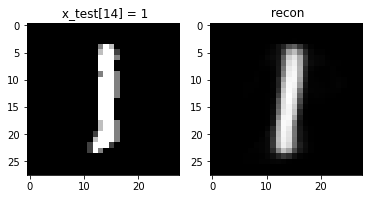

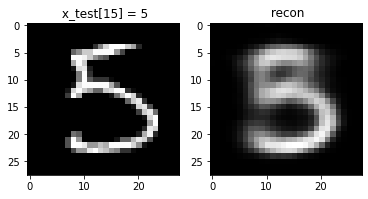

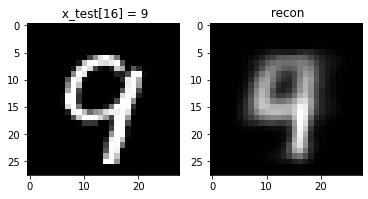

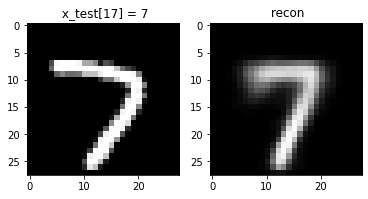

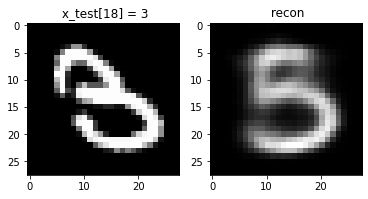

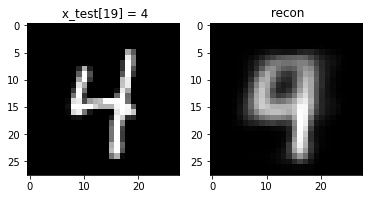

In [ ]:
n = 20
for i in range(n):
   x_recon = vae.predict( np.array( [x_test[i] ] ) )
   # First row is original x_test image
   plt.subplot(1,2,1).set_title( f" x_test[{i}] = {y_test[i] }" )
   plt.imshow( x_test[i].reshape(28,28), cmap=plt.get_cmap('gray') )
   # Second row is the reconstructed image by auto encoder
   plt.subplot(1,2,2).set_title( f" recon" )
   plt.imshow( x_recon.reshape(28, 28), cmap=plt.get_cmap('gray') )
   plt.show()

## 3.6 Generate new image of digits with VAE

In [ ]:
def plot_latent_space( model, n=30, figsize=15 ):
  """ Code from https://keras.io/examples/generative/vae/ """
  # Displaya n*n 2D manifold of digits
  digit_size = 28
  scale = 1.0
  figure = np.zeros( (digit_size* n, digit_size*n ) )

  #Linearly aspaed coordiates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace( -scale, scale, n)
  grid_y = np.linspace( -scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xj in enumerate(grid_x):
      z_sample = np.array([ [xj, yi ]])
      x_decoded = model.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size,digit_size)
      figure[ i*digit_size : (i+1) * digit_size,
              j*digit_size : (j+1) * digit_size,] = digit
  plt.figure(figsize=(figsize,figsize))
  start_range = digit_size//2
  end_range = n * digit_size + start_range
  pixel_range = np.arange( start_range, end_range, end_range)
  sample_range_x = np.round( grid_x, 1)
  sample_range_y = np.round( grid_y, 1)
  plt.xticks( pixel_range, sample_range_x)
  plt.yticks( pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

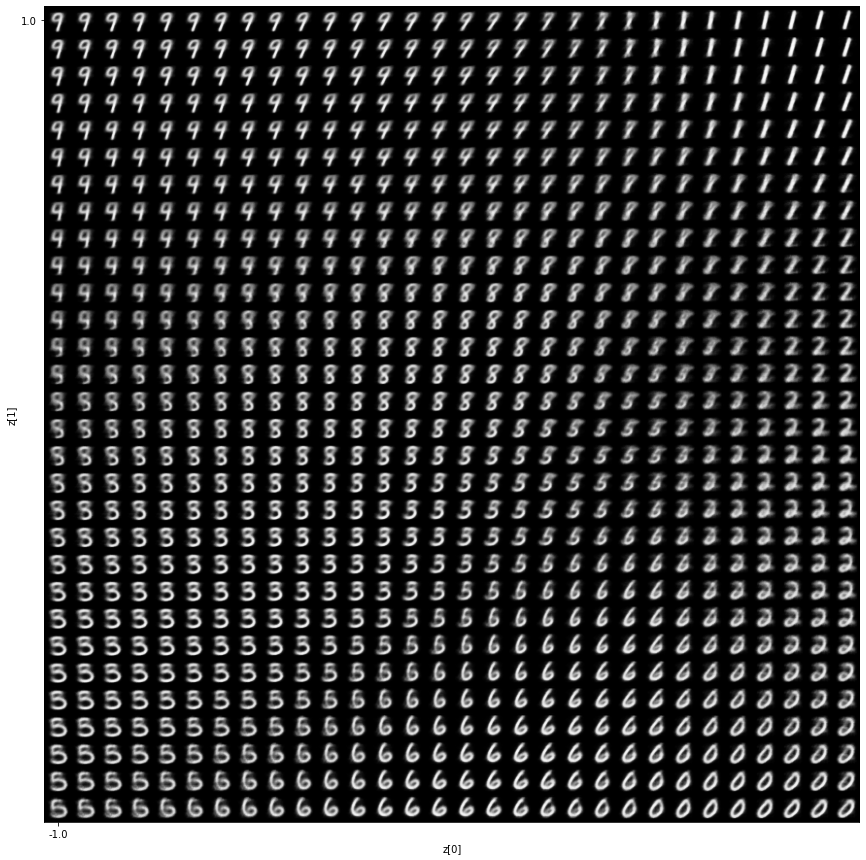

In [ ]:
plot_latent_space(decoder)

## 3.7 Latent Visualization

Visualize latent vectors regrading all samples in x_train to monitor their distribution the below coded are for VAE using latent_dim=2 only.

In [ ]:
def plot_label_clusters(vae_encoder, data, lables):
  """
  Display a 2D plot of the digit classes in latent space
  Codes adapted from
   - Code visualiztion function : https://keras.io/examples/generative/vae/
   - Discrete color bar with middle tickes : https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
  """
  #Forward pass
  z_mean, _, _ = vae_encoder.predict(data)

  # Create a discrete colormap of exactly 10 clusters
  cmap = plt.get_cmap('Paired', np.max(lables) - np.min(lables)+1)

  # Set fughre's size and gridline
  plt.figure( figsize=(12,10))
  plt.grid(b=True, which='major', axis='both', linestyle='--', linewidth=1)

  # Set limits .5 outside ture range
  plt.scatter( z_mean[:,0], z_mean[:,1], c=lables, cmap=cmap
              , vmin=np.min(lables)-.5
              , vmax=np.max(lables)+.5)
  # Tell the colorbar to tick at integers
  plt.colorbar( ticks=np.arange( np.min(lables), np.max(lables)+1 ))

  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show()

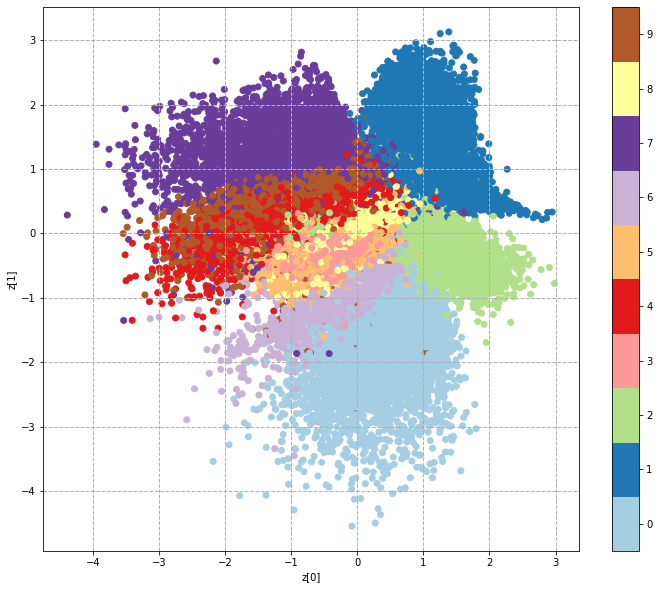

In [ ]:
plot_label_clusters( encoder, x_train, y_train)